In [10]:
from pathlib import Path
import pandas as pd

# 1. Define repo root & data-raw path
ROOT = Path().resolve().parents[1]       # one level up from current working directory
DATA_RAW = ROOT / 'data-raw'
OUTPUT_DIR = ROOT / 'outputs' / 'plots'

In [11]:
from pathlib import Path
import pandas as pd

# 1. Define repo root & data-raw path
ROOT     = Path().resolve().parents[1]   # one level up from cwd
DATA_RAW = ROOT / 'data-raw'

# 2. List the 4 triennial TIF detail files
tif_files = {
    2014: DATA_RAW / 'TifDetails-TY2014-2025-05-22.xlsx',
    2017: DATA_RAW / 'TifDetails-TY2017-2025-05-22.xlsx',
    2020: DATA_RAW / 'TifDetails-TY2020-2025-05-22.xlsx',
    2023: DATA_RAW / 'TifDetails-TY2023-2025-07-17.xlsx',
}

# 3. Jefferson Township TaxDistrict codes (no leading zeros)
JEFF_DISTRICTS = [170, 171, 175, 27, 67]

# 4. Loop through each year’s file, filter & compute taxable totals
tif_totals = []
for year, fp in tif_files.items():
    # read with TaxDistrict as string (to preserve any leading zeros)
    df = pd.read_excel(fp, dtype={'TaxDistrict': str})
    
    # normalize TaxDistrict: drop leading zeros, convert to int
    df['TaxDistrict'] = df['TaxDistrict'].str.lstrip('0').astype(int)
    
    # keep only Jefferson Township parcels
    df = df[df['TaxDistrict'].isin(JEFF_DISTRICTS)]
    
    # pick appraised if present, otherwise assessed
    df['base_value'] = df['AppraisedTotal'].fillna(df['AssessedTotal'])
    
    # taxable value = 35% of base
    df['taxable_value'] = 0.35 * df['base_value']
    
    # sum up
    total_val = df['taxable_value'].sum()
    tif_totals.append({'Year': year, 'total_tif_value': total_val})

# 5. Build DataFrame & compute percent changes
tif_df = (
    pd.DataFrame(tif_totals)
      .sort_values('Year')
      .reset_index(drop=True)
)
tif_df['pct_change'] = tif_df['total_tif_value'].pct_change() * 100

# 6. Compute average triennial percent change
avg_pct_change = tif_df['pct_change'].mean(skipna=True)

# 7. Output
print(tif_df)
print(f"\nAverage triennial % change in TIF taxable value (Jefferson): {avg_pct_change:.2f}%")

   Year  total_tif_value  pct_change
0  2014       16413075.0         NaN
1  2017       21237370.0   29.392999
2  2020       55182120.0  159.834998
3  2023      157024910.0  184.557589

Average triennial % change in TIF taxable value (Jefferson): 124.60%


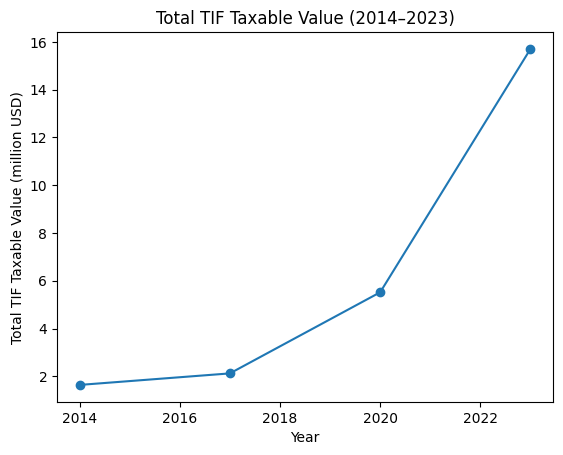

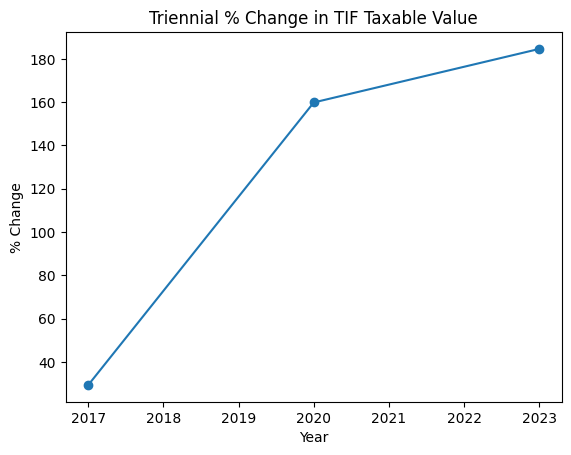

In [15]:
import matplotlib.pyplot as plt 
# Total TIF taxable value
fig, ax = plt.subplots()
ax.plot(tif_df['Year'], tif_df['total_tif_value']/1e7, marker='o')
ax.set_title('Total TIF Taxable Value (2014–2023)')
ax.set_xlabel('Year')
ax.set_ylabel('Total TIF Taxable Value (million USD)')
fig.savefig(OUTPUT_DIR / 'total_tif_value_millions.png', dpi=300, bbox_inches='tight')
plt.show()

# Triennial % change in TIF taxable value
fig, ax = plt.subplots()
ax.plot(tif_df['Year'], tif_df['pct_change'], marker='o')
ax.set_title('Triennial % Change in TIF Taxable Value')
ax.set_xlabel('Year')
ax.set_ylabel('% Change')
fig.savefig(OUTPUT_DIR / 'pct_change_tif_value.png', dpi=300, bbox_inches='tight')
plt.show()